# **DeepLandforms - v2**

Author: giacomo.nodjoumi@hyranet.info - g.nodjoumi@jacobs-university.de

## DeepLandforms

With this notebook, users can use custom [YOLOv8](https://github.com/ultralytics/ultralytics) trained models for object detection and instance segmentation models on custom dataset of georeferenced images.
Results can be visualized directly in the noteboo using leafmap and WMS backend.

The output consist of a folder containing:
* Crop of the detections (georeferenced)
* Label file in YOLO txt format for object detection
* Geopackage containing a single layer with image name, confidence leve, class.

## Usage

* Put or link the dataset into the **DeepLandforms** *.env* file
* Run docker-compose up
* Edit the *configs* section by editing the following parameters:

## Parameters
 ------------------------------------------------------------------
| **Parameter** | **Description** | **Example** |
| ---- | ---- | ---- |
| **data_dir** | local path of the data dir |  | /home/user/data |
| **dst_crs** | CRS of the final geopackage | provide as WKT or proj4 |
| **device** | device where to run the model | cuda or cpu |
------------------------------------------------------------------
Then just execute the notebook and monitor the training in **Tensorboard** container.

## Funding
*This study is within the Europlanet 2024 RI and EXPLORE project, and it has received funding from the European Union’s Horizon 2020 research and innovation programme under grant agreement No 871149 and No 101004214.*

In [1]:
from pyproj.crs import CRS
dst_crs = CRS.from_wkt('GEOGCRS["GCS_Mars_2000",DATUM["D_Mars_2000",ELLIPSOID["Mars_2000_IAU_IAG",3396190,169.894447223612,LENGTHUNIT["metre",1]]],PRIMEM["Reference_Meridian",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Not known."],AREA["World."],BBOX[-90,-180,90,180]],ID["ESRI",104905]]')

In [2]:
from ultralytics import YOLO
import geopandas as gpd
import json
import math
import numpy as np
import os
import pandas as pd
import rasterio as rio
from utils.utils import get_paths, window_calc, mask2shape, bboxes2df, bbox2points, box2geotiff,PlotMap

In [3]:
test_dir = '/home/Giacomo/data/test'
dst_dir = f"{test_dir}/detections"
os.makedirs(dst_dir, exist_ok=True)

In [4]:
model_path= '/home/Giacomo/DeepLandforms/DeepLearning/DeepLandforms/Dockerbuild/Notebooks/YOLO/runs/detect/yolov8x_custom_640_multiclass_10m_Augm/weights/best.pt'
model = YOLO(model_path)

In [5]:
image_list = get_paths(test_dir, 'tiff')

In [6]:
cols = ['Image','Class','Conf']
geo_shape = gpd.GeoDataFrame(columns=cols)#, crs=img.crs)
geo_points = gpd.GeoDataFrame(columns=cols)#, crs=dst_crs)

In [7]:
for file in image_list:
    image=f"{test_dir}/{file}"
    image_name, ext = os.path.splitext(os.path.basename(image))
    image_dir = os.path.dirname(image)
    img = rio.open(image)    
    aff = img.transform
    width = img.width
    height = img.height
    img_crs = img.crs
    results = model.predict(image, project="project",name="prediction")#, imgsz=1024, conf=0.6)#, iou=0.3)#, half=True)  # predict on an imagesave_crop=True, save_txt=True, save_conf=True, 
    for result in results:#
        bboxes = np.array(result.boxes.data.cpu())
        xywh_bboxes = np.array(result.boxes.xywhn.data.cpu())
        classes = np.array(result.boxes.cls.data.cpu())
        confs = np.array(result.boxes.conf.data.cpu())
        shapes=[]
        for i, data in enumerate(bboxes):    
            bbox = data[0:4]
            conf = round(data[4],2)
            cls = result.names[data[5]]
            dst_name = box2geotiff(bbox, img,dst_dir, image_name, ext, cls, i)  
        yolo_fdf = bboxes2df(xywh_bboxes, classes,confs, cols=['x','y','w','h'])
        yolo_sdf=yolo_fdf[['Class','x','y','w','h']]#,'Conf']]
        csv_name = f"{dst_dir}/{image_name}.txt"
        yolo_sdf.to_csv(csv_name, header=False, sep=' ', index=False)        
        yolo_gdf = bbox2points(yolo_fdf, image)#xywh_bboxes, image_name,width, height,image)        
        if yolo_gdf.crs != dst_crs:            
            yolo_gdf.to_crs(dst_crs, inplace=True)
        geo_points=pd.concat([yolo_gdf, geo_points])
geo_points.reset_index(drop=True)
geo_points.crs=dst_crs
point_gpkg = f"{dst_dir}/point_detections.gpkg"
#geo_points.to_crs(dst_crs, inplace=True)
geo_points.to_file(point_gpkg, layer='PointDetections', driver="GPKG")


image 1/1 /home/Giacomo/data/test/B08_012600_1656_XN_14S120W.tiff: 640x448 1 Type-2, 3 Type-3s, 6 Type-4s, 2 Craters, 28.5ms
Speed: 2.4ms preprocess, 28.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/Giacomo/data/test/B08_012903_2163_XN_36N118W.tiff: 640x192 1 Type-1, 1 Type-2, 1 Type-4, 1 Crater, 22.2ms
Speed: 2.3ms preprocess, 22.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/Giacomo/data/test/ESP_012600_1655_RED_resized_3.0m.tiff: 640x256 1 Type-1, 3 Type-3s, 13 Type-4s, 2 Craters, 22.2ms
Speed: 0.9ms preprocess, 22.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [8]:
map_select = PlotMap(geo_points)

Image must by in EPSG:4326


In [9]:
map_select.zoom_to_gdf(geo_points)
map_select

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

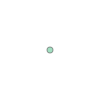

In [10]:
geo_points.iloc[0].geometry